Before you start
==================================



If you will use Google Colab to accomplish this exercise you might find helpful the following steps:

- Upload a file ```archive.zip``` with the dataset to your Google Drive;
- Import needed packages:

In [ ]:
from google.colab import drive
from os import listdir as ls, path
drive.mount('/content/drive')

- Unzip the archive

In [ ]:
!unzip -q '/content/drive/My Drive/archive.zip'

# Description

We divided the final assignment into several subtasks. You **need** to accomplish the first, ```base```, assignment and one more of your choice. 

Each subtask is worth five points. The maximum number of points for this task is 10.
 
Nevertheless, you are allowed to try to accomplish as many exercises as you want. Extra points that you earn will be counted if you have an assignment with a non-maximum mark.

Good luck!
==========================================

# Base assignment
 
Train a multiclass classification neural network on [this dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification).
 
Your baseline should have accuracy at least 86%.
 
- Submit plots of values of a loss function and accuracy on train and validation dataset.
- Print the maximum obtained value of accuracy.
 
Please don't use the code from Kaggle (take into account that we also have access to those).


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/kaggle/input/archive/seg_train/seg_train'
test_dir = '/kaggle/input/archive/seg_test/seg_test'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)  

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    target_size=(150, 150),
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                        batch_size=64,
                                                        target_size=(150, 150),
                                                        class_mode='categorical')

print(train_generator.class_indices)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


Epoch 1/5
train Loss: 0.6598 Acc: 0.7589
val Loss: 0.4020 Acc: 0.8663
Epoch 2/5
train Loss: 0.5147 Acc: 0.8109
val Loss: 0.3402 Acc: 0.8763
Epoch 3/5
train Loss: 0.4488 Acc: 0.8381
val Loss: 0.3743 Acc: 0.8697
Epoch 4/5
train Loss: 0.4184 Acc: 0.8479
val Loss: 0.3353 Acc: 0.8797
Epoch 5/5
train Loss: 0.4225 Acc: 0.8482
val Loss: 0.3828 Acc: 0.8700
Training complete!


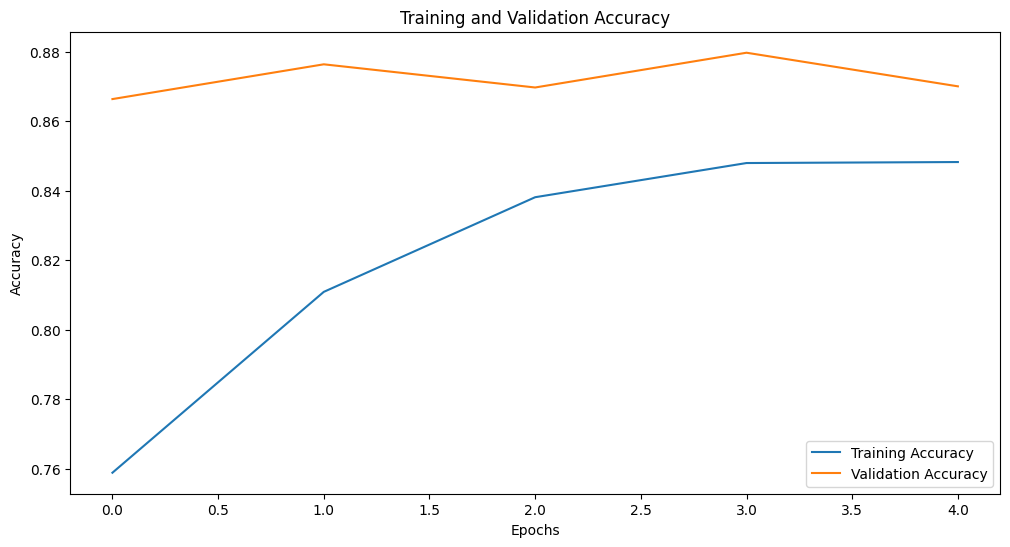

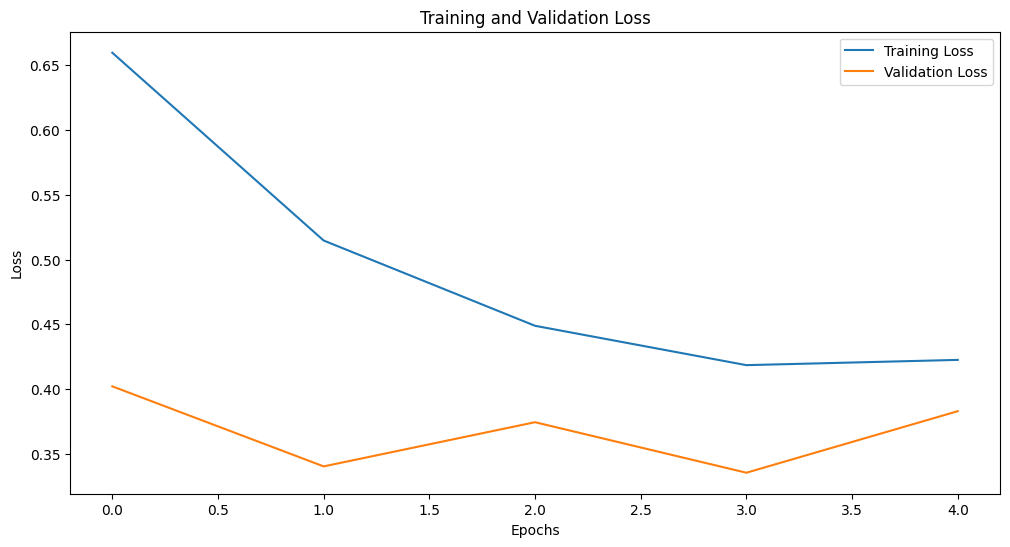

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(150),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(test_dir, data_transforms['val'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=64)
}

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accs = []
val_accs = []
train_losses = []
val_losses = []

num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        if phase == 'train':
            train_accs.append(epoch_acc.item())
            train_losses.append(epoch_loss)
        else:
            val_accs.append(epoch_acc.item())
            val_losses.append(epoch_loss)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

print("Training complete!")

plt.figure(figsize=(12, 6))
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


# Snapshot learning

In lectures we discussed an approach for ensemble learning called snapshot ensemble. In this approach one trains a neural network with the cosine annealing with restarts scheduler and takes to the ensemble neural networks from the end of each period (with the minimum value of the learning rate).

To accomplish this exercise:
- Train a neural network with the cosine annealing with restarts scheduler;
- Plot a graph of the learning rate;
- Submit a table of accuracies of individual neural networks and the whole ensemble (ensemble output could be average of logits or probabilities, check both possibilities);
- Submit a table of pairwise correlation between errors on validation dataset of different models.


Epoch 1/5
train Loss: 0.6143 Acc: 0.7768
val Loss: 0.2963 Acc: 0.9013
Epoch 2/5
train Loss: 0.4792 Acc: 0.8282
val Loss: 0.2597 Acc: 0.9110
Epoch 3/5
train Loss: 0.4446 Acc: 0.8392
val Loss: 0.4883 Acc: 0.8333
Epoch 4/5
train Loss: 0.3979 Acc: 0.8542
val Loss: 0.2434 Acc: 0.9190
Epoch 5/5
train Loss: 0.3489 Acc: 0.8732
val Loss: 0.3759 Acc: 0.8703
Training complete!


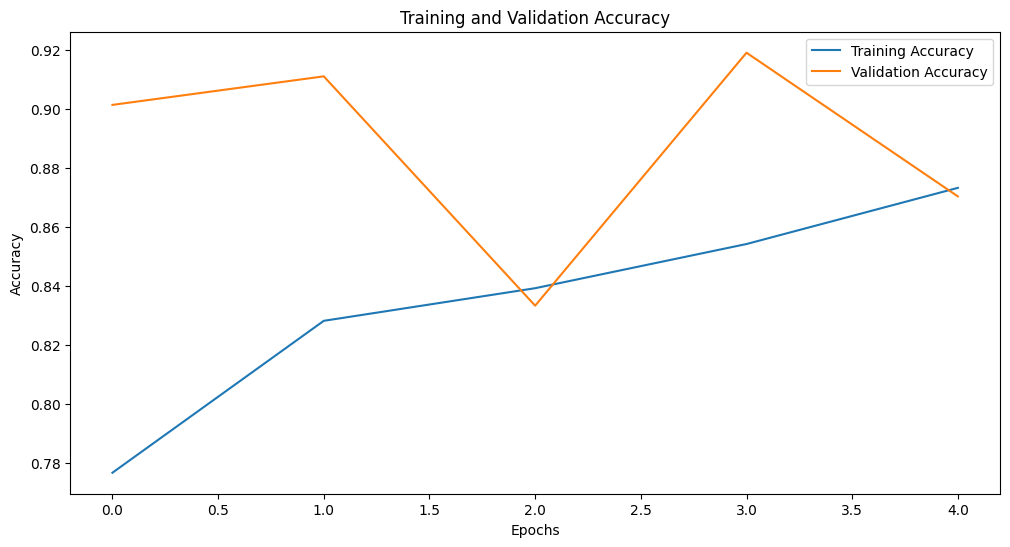

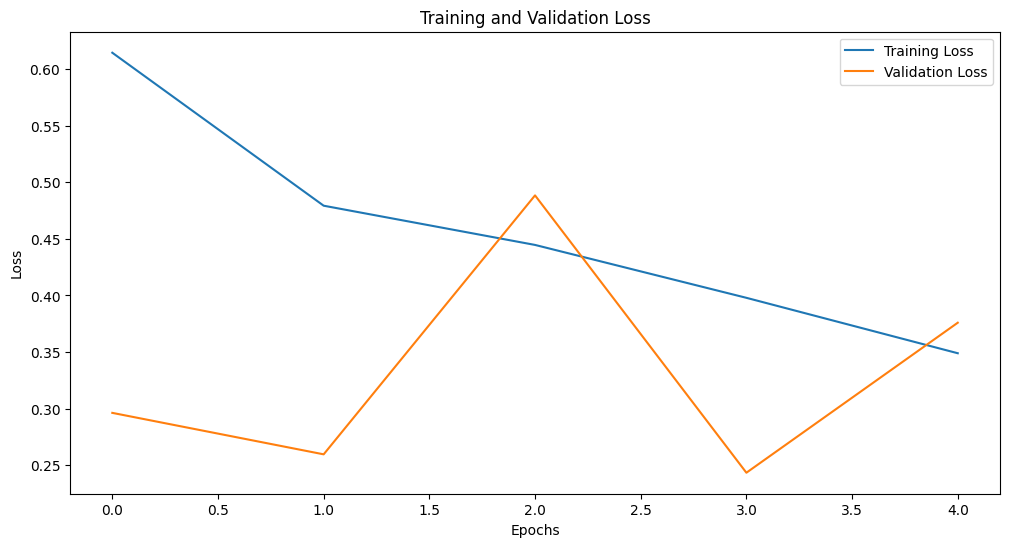

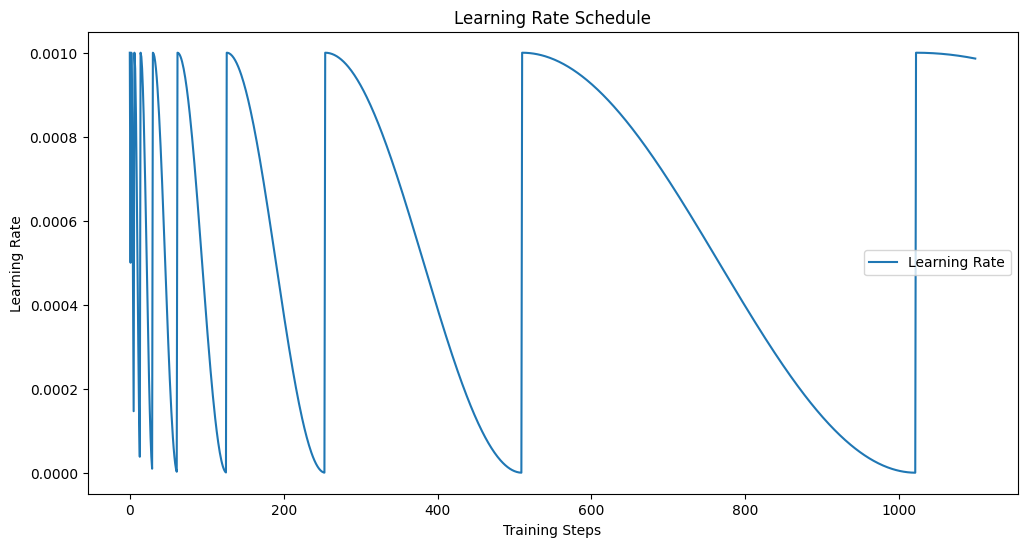

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(150),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(test_dir, data_transforms['val'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=64)
}

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

T_0 = 1  
T_mult = 2  
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

train_accs = []
val_accs = []
train_losses = []
val_losses = []
lr_rates = []

num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    lr_rates.append(optimizer.param_groups[0]['lr'])

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        if phase == 'train':
            train_accs.append(epoch_acc.item())
            train_losses.append(epoch_loss)
        else:
            val_accs.append(epoch_acc.item())
            val_losses.append(epoch_loss)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    if (epoch + 1) % T_0 == 0:
        torch.save(model.state_dict(), f'snapshot_model_epoch_{epoch+1}.pth')

print("Training complete!")

plt.figure(figsize=(12, 6))
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(lr_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.legend()
plt.title("Learning Rate Schedule")
plt.show()


# Hyperparameter optimization

In week 5 we discussed how we could optimize hyperparameters uisng ```ray```.

Use ```ray``` or ```optuna``` to optimize hyperparameters.

Sumbit accuracy of the optimized setting and compare it to the baseline.

In [ ]:
import optuna

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    
    val_accuracy = train_model_with_hyperparameters(lr, dropout)
    
    return val_accuracy  

def train_model_with_hyperparameters(lr, dropout):
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(num_ftrs, 6)
    )

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

    num_epochs = 5
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(image_datasets['train'])
        if epoch_acc > best_acc:
            best_acc = epoch_acc

    return best_acc.item()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
best_accuracy = study.best_value

print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy}")


# GBDT on exctracted features 
In lecure about feature visualization we used our Neural Network as feature extractor for visualization. In this task we ask you to use extracted features of final task's Neural Network to build another model on them, preferably a GBDT (Gradient Boosting Decision Tree). 

To accomplish this exercise:

- Use the neural network from the first task to create a feature extractor
- Extract features from the images of the dataset;
- Train a GBDT model on these features with any library you like. Suggestions: LightGBM, XGBoost, CatBoost;
- Submit the accuracy of this model and compare it to baseline.


In [8]:
feature_extractor = models.resnet50(pretrained=False)
feature_extractor = feature_extractor.to(device)

model_state_dict = model.state_dict()
model_state_dict.pop('fc.weight')
model_state_dict.pop('fc.bias')

feature_extractor.load_state_dict(model_state_dict, strict=False)
feature_extractor.fc = nn.Identity()  

feature_extractor.eval() 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
def extract_features(dataloader, model):
    features = []
    labels = []

    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return features, labels

train_features, train_labels = extract_features(dataloaders['train'], feature_extractor)
val_features, val_labels = extract_features(dataloaders['val'], feature_extractor)


In [10]:
import lightgbm as lgb

train_data = lgb.Dataset(train_features, label=train_labels)
val_data = lgb.Dataset(val_features, label=val_labels, reference=train_data)

params = {
    'objective': 'multiclass',
    'num_class': 6,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss'
}

gbm = lgb.train(params,
                train_data,
                valid_sets=val_data,
                num_boost_round=500,
                early_stopping_rounds=10)

val_preds = np.argmax(gbm.predict(val_features, num_iteration=gbm.best_iteration), axis=1)
accuracy = np.mean(val_preds == val_labels)

print(f"Accuracy of GBDT on extracted features: {accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.455330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522240
[LightGBM] [Info] Number of data points in the train set: 14034, number of used features: 2048
[LightGBM] [Info] Start training from score -1.857125
[LightGBM] [Info] Start training from score -1.821263
[LightGBM] [Info] Start training from score -1.764349
[LightGBM] [Info] Start training from score -1.720404
[LightGBM] [Info] Start training from score -1.819943
[LightGBM] [Info] Start training from score -1.773542
[1]	valid_0's multi_logloss: 1.41716
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.18637
[3]	valid_0's multi_logloss: 1.02
[4]	valid_0's multi_logloss: 0.893246
[5]	valid_0's multi_logloss: 0.792353
[6]	valid_0's multi_logloss: 0.711917
[7]	valid_0's multi_logloss: 0.645146
[8]	valid_0's multi_logloss: 0.590083
[9]	valid_0's multi_l

# Class activation mapping
In this task we ask you to create so-called Class Activation Mapping (CAM). This tetechnique is firstly introduced in paper "Learning Deep Features for Discriminative Localization", Zhou, Bolei, et al, 2016 (https://arxiv.org/abs/1512.04150) and further developed in "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization" Selvaraju, Ramprasaath R., et al, 2017 (https://arxiv.org/abs/1610.02391).
Original CAM is easier to create, but it is required to have global avareging pool in your neural network. 

To accomplish this exercise:

- Create either original CAN or grad-CAM of both train and test images of different classes and compare it to your expectations. This tecnique doesn't always work the way we expect so its okay to be dissapoined.

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


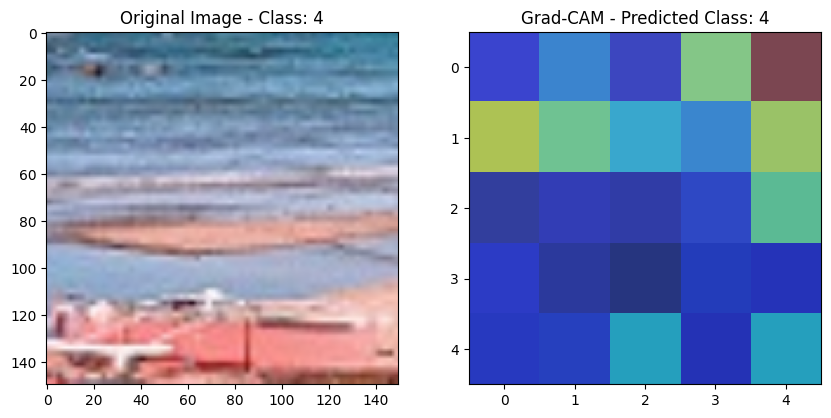

In [18]:
import cv2
import torch.nn.functional as F

def grad_cam(model, image, target_class, feature_layer):
    model.eval()
    
    activations = []
    gradients = []
    
    def forward_hook(module, input, output):
        activations.append(output)
        
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    h_forward = feature_layer.register_forward_hook(forward_hook)
    h_backward = feature_layer.register_backward_hook(backward_hook)
    
    output = model(image)
    _, pred_class = output.max(dim=1)
    
    model.zero_grad()
    
    class_score = output[0, target_class]
    class_score.backward()
    
    h_forward.remove()
    h_backward.remove()

    activation = activations[0]
    gradient = gradients[0]

    pooled_gradients = torch.mean(gradient, dim=[0, 2, 3])

    for i in range(activation.shape[1]):
        activation[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activation, dim=1).squeeze()
    
    heatmap = F.relu(heatmap)
    
    heatmap = heatmap / torch.max(heatmap)
    
    return heatmap.detach().cpu().numpy(), pred_class.item()

image, label = next(iter(dataloaders['train']))
image = image.to(device)

feature_layer = model.layer4[-1]

single_image, single_label = image[0:1], label[0]

saliency_map, pred_class = grad_cam(model, single_image, single_label.item(), feature_layer)

fig, axarr = plt.subplots(1, 2, figsize=(10,5))

unnormalized_img = single_image.squeeze().permute(1,2,0).cpu().numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
axarr[0].imshow(unnormalized_img)
axarr[0].set_title(f"Original Image - Class: {single_label.item()}")

axarr[1].imshow(unnormalized_img)
axarr[1].imshow(saliency_map, cmap='jet', alpha=0.5)
axarr[1].set_title(f"Grad-CAM - Predicted Class: {pred_class}")

plt.show()
